# VAE Analysis - Faces dataset

## imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import pandas as pd

from utils.data.FaceDataset import FaceDataset
from models.CelebVariationalAutoencoder import CelebVariationalAutoencoder
from torchvision import datasets, transforms
from scipy.stats import norm

In [2]:
bs = 10
ds = FaceDataset("data/faces/img_align_celeba/")
dl = t.utils.data.DataLoader(dataset=ds, batch_size=bs, shuffle=False, drop_last=True)
z_dim = 200
device = t.device('cuda') if t.cuda.is_available() else 'cpu'
model = CelebVariationalAutoencoder(ds[0][0][None], in_c=3, enc_out_c=[32, 64, 64, 64],
                               enc_ks=[3, 3, 3, 3], enc_pads=[1, 1, 0, 1], enc_strides=[1, 2, 2, 1],
                               dec_out_c=[64, 64, 32, 3], dec_ks=[3, 3, 3, 3], dec_strides=[1, 2, 2, 1],
                               dec_pads=[1, 0, 1, 1], dec_op_pads=[0, 1, 1, 0], z_dim=z_dim)
model.cuda(device)
model.load_state_dict(t.load('models/state_dicts/03_05_full.pth'))

t.set_grad_enabled(False)
encoder = model.enc_conv_layers
lambda_layer = model.lambda_sampling_layer
decoder = model.dec_conv_layers

In [3]:
def encode(imgs):
    return lambda_layer(encoder(imgs.to(device)))

In [4]:
examples, _ = next(iter(dl))
examples.shape

torch.Size([10, 3, 128, 128])

## reconstructing faces

In [5]:
n_to_show = bs
z_points = encode(examples)
reconst_images = decoder(z_points)

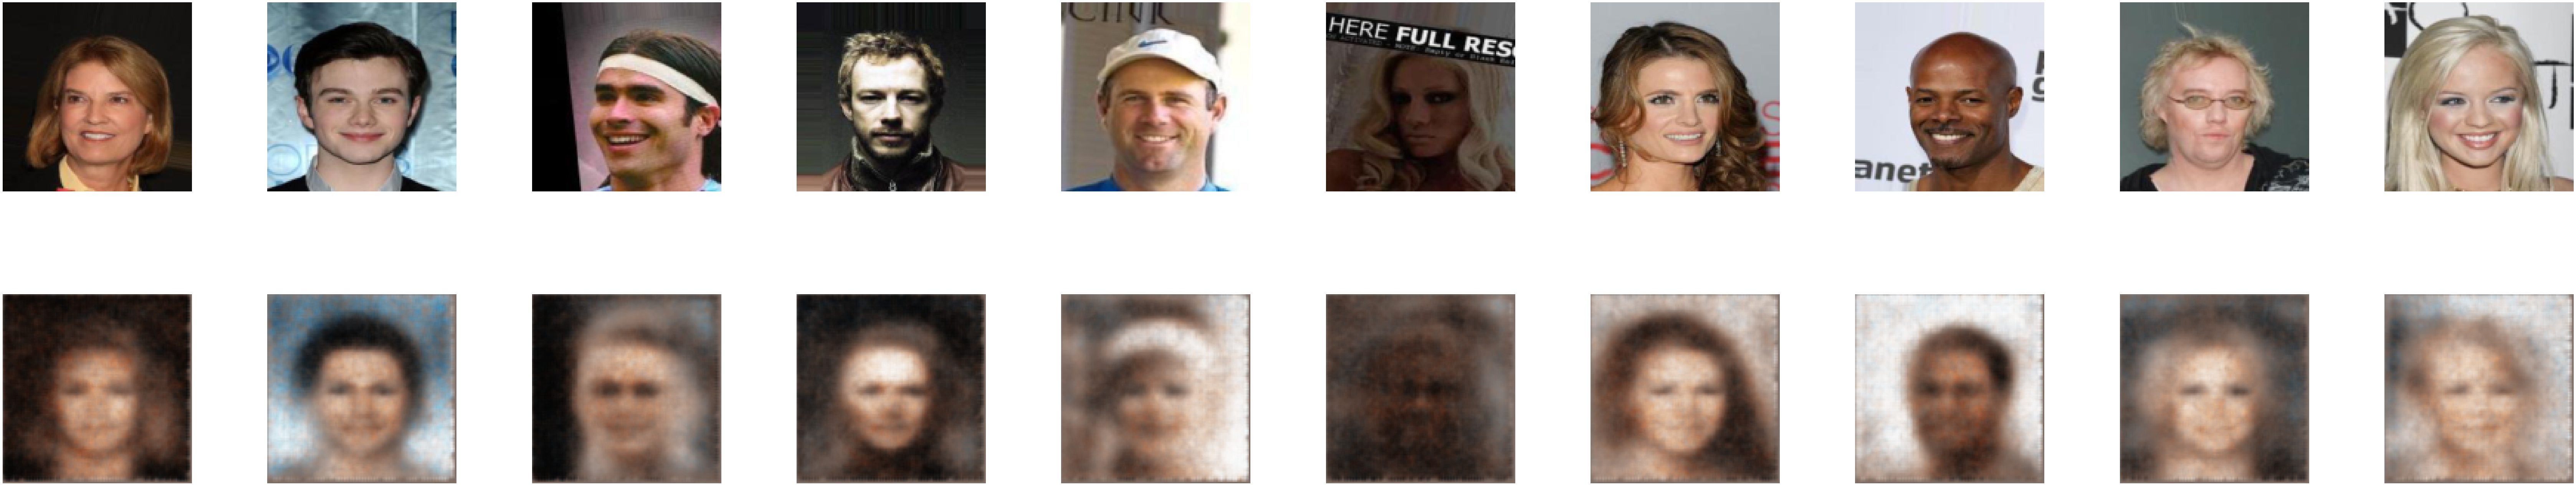

In [6]:
fig = plt.figure(figsize=(120, 24))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = examples[i].permute(1, 2, 0).cpu().numpy()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].permute(1, 2, 0).cpu().numpy()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)


## Latent space distribution

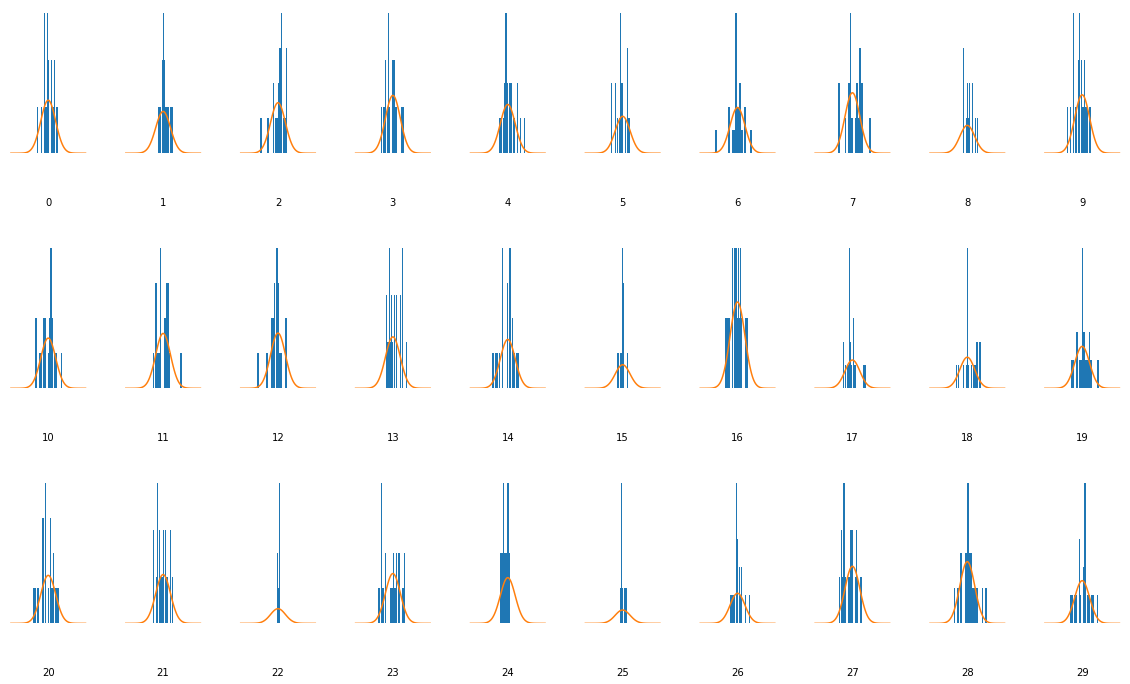

In [7]:
dl = t.utils.data.DataLoader(dataset=ds, batch_size=20, shuffle=False, drop_last=True)

examples, _ = next(iter(dl))
examples.shape
z_test = encode(examples).cpu()
x = np.linspace(-5, 5, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(30):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### Newly generated faces

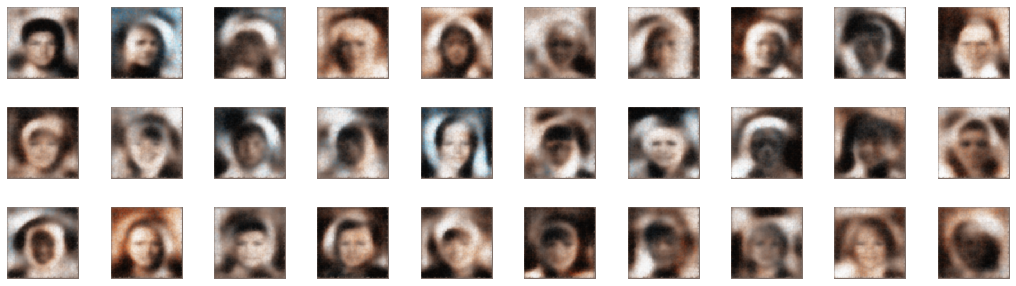

In [8]:
n_to_show = 30
np.random.seed(20)
znew = np.random.normal(size = (n_to_show, z_dim))
reconst = decoder(t.tensor(np.array(znew)).float().to(device))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i + 1)
    ax.imshow(reconst[i, :,:,:].permute(1, 2, 0).cpu())
    ax.axis('off')

plt.show()

In [9]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

face_labels = 'data/face_labels.txt'
if not os.path.exists(face_labels):
    gdd.download_file_from_google_drive(file_id='0B7EVK8r0v71pblRyaVFSWGxPY0U',dest_path=face_labels)

In [10]:
fl_df = pd.read_csv(face_labels, skiprows=1, sep='\s+', error_bad_lines=False)

In [11]:
print(fl_df.columns.tolist())

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [12]:
fl_df.head()

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1        -1        -1          -1          -1  ...   
000005.jpg    -1     -1         1        -1          -1          -1  ...   

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
000001.jpg         -1        1              1         -1                 1   
000002.jpg         -1        1             -1         -1                -1   
000003.jpg         -1       -1             -1          1                -1   
000004.jpg         -1       -1              1         -1                 1   
000005.jpg         -1       -1             -1         -1                -1   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
000001.jpg           -1                 1                -1               -1   
000002.jpg           -1                -1                -1               -1   
000003.jpg           -1                -1                -1               -1   
000004.jpg           -1                 1                 1               -1   
000005.jpg           -1                 1                -1               -1   

            Young  
000001.jpg      1  
000002.jpg      1  
000003.jpg      1  
000004.jpg      1  
000005.jpg      1  

[5 rows x 40 columns]

In [13]:
def get_vector_from_label(label, batch_size):
    fl_dl = t.utils.data.DataLoader(dataset=ds, batch_size=batch_size, shuffle=False, drop_last=True)
    pics_with_label = set(fl_df[fl_df[label] == 1].index)

    pos_count, neg_count, dist = 0, 0, 0
    z_dim_ndarray = np.zeros(shape=z_dim, dtype='float32')
    pos_mean, neg_mean = np.copy(z_dim_ndarray), np.copy(z_dim_ndarray)
    pos_sum, neg_sum = np.copy(z_dim_ndarray), np.copy(z_dim_ndarray)
    result = np.copy(z_dim_ndarray)

    print('label: ', label)
    print('images : POS move : NEG move :distance : 𝛥 distance')

    for imgs, labels in dl:
        z = encode(imgs)
        pos_z = z[[i for i, label in enumerate(labels) if label in pics_with_label]]
        neg_z = z[[i for i, label in enumerate(labels) if label not in pics_with_label]]
        pos_count += len(pos_z)
        neg_count += len(neg_z)

        if pos_z.numel():
            pos_sum += t.sum(pos_z, dim=0).cpu().numpy()
            new_pos_mean = pos_sum / pos_count
            pos_delta = np.linalg.norm(new_pos_mean - pos_mean)
            pos_mean = new_pos_mean

        if neg_z.numel():
            neg_sum += t.sum(neg_z, dim=0).cpu().numpy()
            new_neg_mean = neg_sum / neg_count
            neg_delta = np.linalg.norm(new_neg_mean - neg_mean)
            neg_mean = new_neg_mean

        result = new_pos_mean - new_neg_mean
        new_dist = np.linalg.norm(result)
        dist_delta = new_dist - dist
        dist = new_dist

        print(str(pos_count)
              + '    : ' + str(np.round(pos_delta, 3)) + '    : ' + str(np.round(neg_delta, 3))
              + '    : ' + str(np.round(new_dist, 3)) + '    : ' + str(np.round(dist_delta, 3)))

        if np.sum([pos_delta, neg_delta]) < 0.01:
            result = result / dist
            print('Found the ' + label + ' vector', pos_count)
            break

    return t.from_numpy(result).to(device)

### make sure to run this, I cleared the output though because it was too long for git, but all my notebooks should run top to bottom `.)

In [ ]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

In [15]:
def add_vector_to_images(feature_vec):
    n_to_show = 5
    dl = t.utils.data.DataLoader(dataset=ds, batch_size=n_to_show, shuffle=True, drop_last=True)
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    imgs, labels = next(iter(dl))
    z_points = encode(imgs)
    fig = plt.figure(figsize=(18, 10))
    print(z_points.shape, feature_vec.shape)

    counter = 1
    for i in range(n_to_show):
        img = imgs[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')
        sub.imshow(img.permute(1, 2, 0).cpu().numpy())
        counter += 1
        for factor in factors:
            changed_z_points = z_points[i] + feature_vec * factor
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(decoder(changed_z_points[None]).squeeze().permute(1, 2, 0).cpu().numpy())
            counter += 1
    plt.show()

Eyeglasses Vector
torch.Size([5, 200]) torch.Size([200])


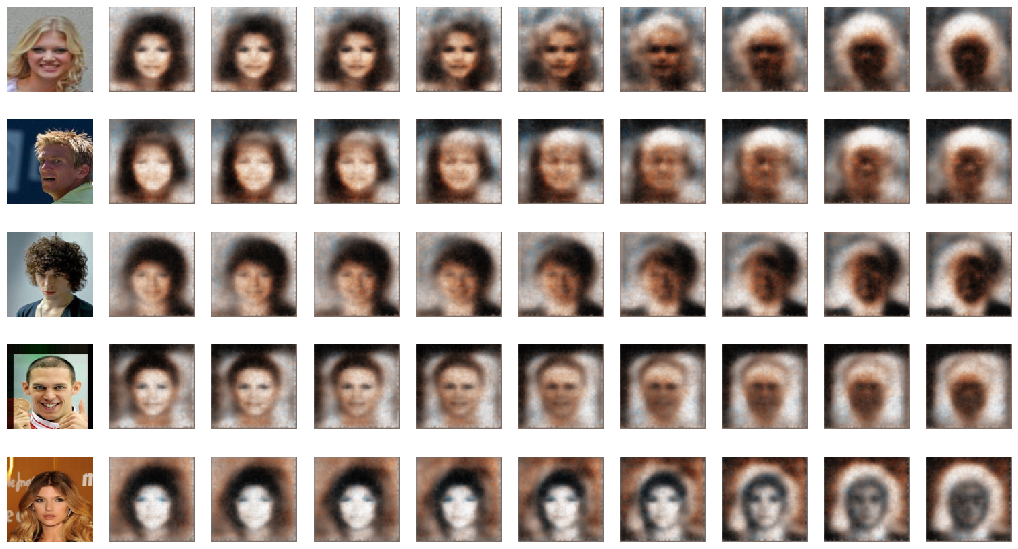

In [30]:
print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

Mouth Open Vector
torch.Size([5, 200]) torch.Size([200])


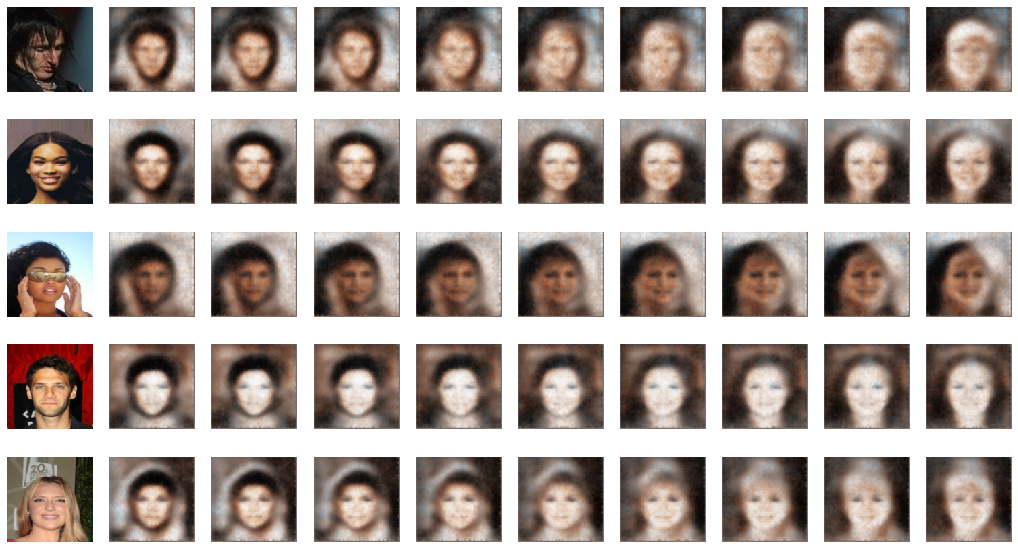

In [26]:
print('Mouth Open Vector')
add_vector_to_images(mouth_open_vec)

Smiling Vector
torch.Size([5, 200]) torch.Size([200])


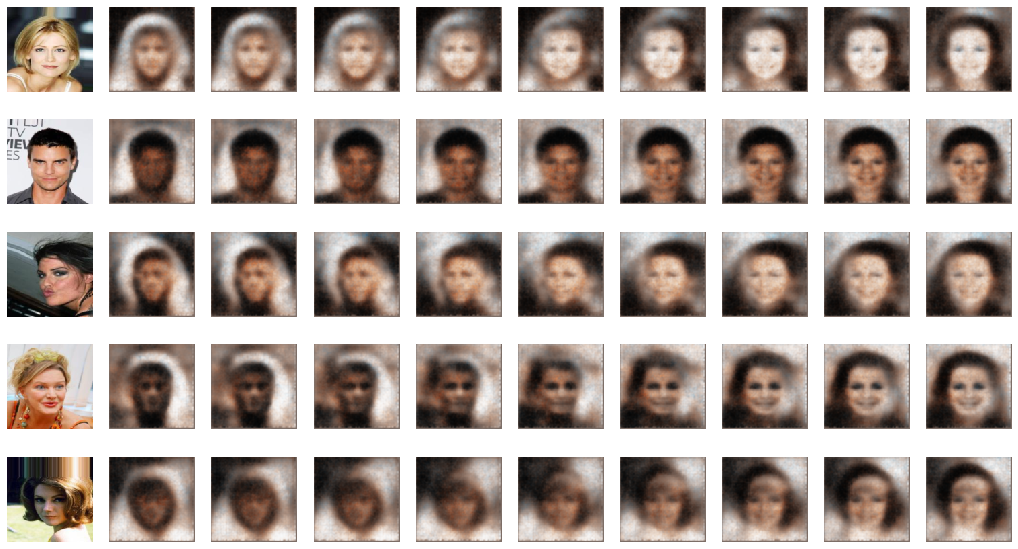

In [18]:
print('Smiling Vector')
add_vector_to_images(smiling_vec)

Male Vector
torch.Size([5, 200]) torch.Size([200])


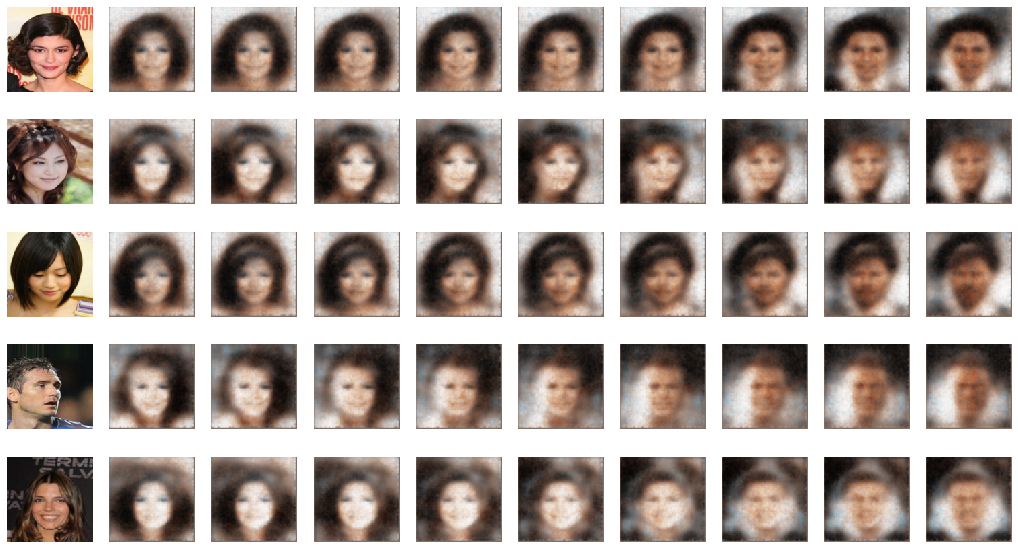

In [19]:
print('Male Vector')
add_vector_to_images(male_vec)

Blond Vector
torch.Size([5, 200]) torch.Size([200])


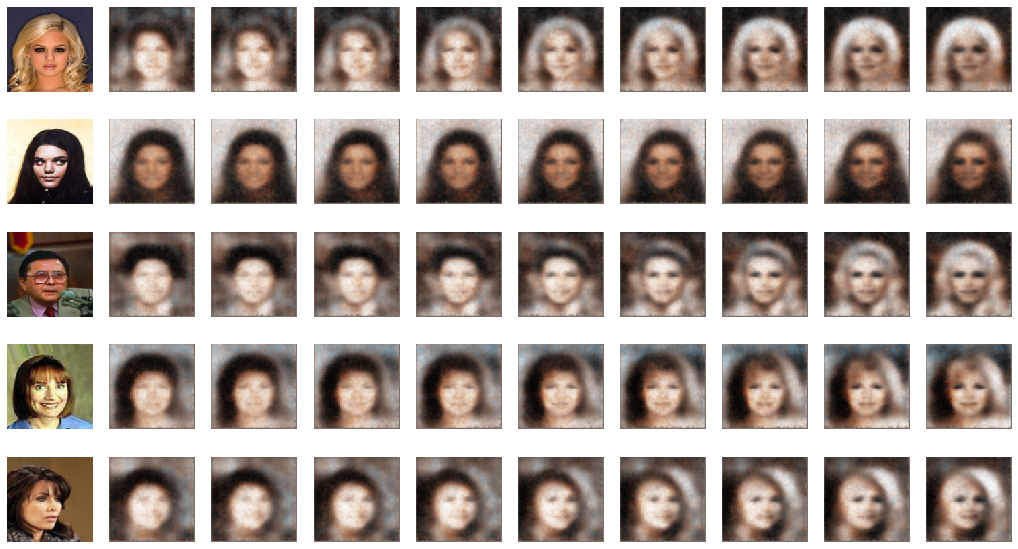

In [31]:
print('Blond Vector')
add_vector_to_images(blonde_vec)

In [21]:
def morph_faces(img_a, img_b):
    factors = np.arange(0, 1, 0.1)
    z_points = encode(t.tensor([img_a.numpy(), img_b.numpy()]))
    fig = plt.figure(figsize=(18, 8))
    counter = 1

    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis('off')
    sub.imshow(img_a.permute(1, 2, 0).cpu().numpy())
    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis('off')
        sub.imshow(decoder(changed_z_point[None]).squeeze().permute(1, 2, 0).cpu().numpy())
        counter += 1

    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis('off')
    sub.imshow(img_b.permute(1, 2, 0).cpu().numpy())
    plt.show()

In [22]:
dl = t.utils.data.DataLoader(dataset=ds, batch_size=6, shuffle=True, drop_last=True)
imgs, labels = next(iter(dl))

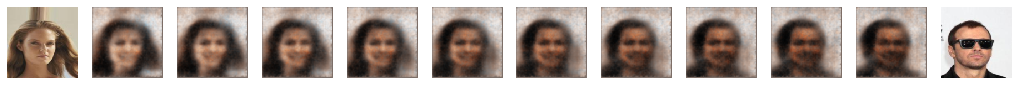

In [23]:
img_a = ds.get_item_by_jpg('000238.jpg')
img_b = ds.get_item_by_jpg('000193.jpg') #glasses
morph_faces(img_a, img_b)

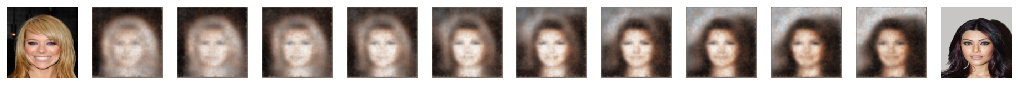

In [24]:
img_a = ds.get_item_by_jpg('000112.jpg')
img_b = ds.get_item_by_jpg('000258.jpg') 
morph_faces(img_a, img_b)

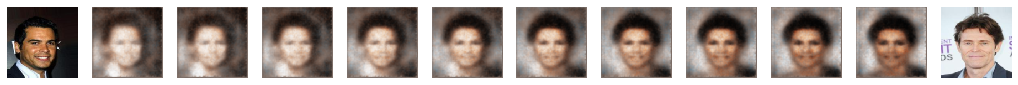

In [25]:
img_a = ds.get_item_by_jpg('000230.jpg')
img_b = ds.get_item_by_jpg('000712.jpg') 
morph_faces(img_a, img_b)